# DeepLoc learning notebook
To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step.

In [1]:
import sys
sys.path.append('../../')
import ipywidgets as widgets
from IPython.display import display
import stackview
import datetime

import ailoc.deeploc
import ailoc.common
ailoc.common.setup_seed(42)

%matplotlib inline

## 1. Set the necessary parameters to train the network, mainly about the training data simulation

In [2]:
deeploc_learn_param_widget = ailoc.common.DeepLocSetLearnParamWidget()
deeploc_learn_param_widget.display_notebook_gui()

SelectFilesButton(description='Optional: select the experiment file to estimate background range', icon='squar…

SelectFilesButton(description='Select the calibration file', icon='square-o', layout=Layout(height='80px', wid…

Button(description='Load from calib', style=ButtonStyle())

Label(value='PSF parameters', style=LabelStyle(font_weight='bold'))

SetPSFParamWidget(children=(BoundedFloatText(value=1.5, description='NA:', layout=Layout(grid_area='widget001'…

Label(value='Camera parameters', style=LabelStyle(font_weight='bold'))

Dropdown(description='Camera type:', index=1, options=('Idea Camera', 'sCMOS', 'EMCCD'), value='sCMOS')

GridspecLayout(children=(sCMOSParamWidget(children=(BoundedFloatText(value=0.81, description='QE:', layout=Lay…

SetSamplerParamWidget(children=(Label(value='Sampler parameters', layout=Layout(grid_area='widget001'), style=…

Button(description='OK', style=ButtonStyle())

Output()

## Optional: using the provided experimental image to estimate the background range

<tifffile.TiffTag 270 @491320> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'\x83\x00\x90\x00\x83\x00\x8b\x00\x80\x00\x93\x00x\x00x\x00\x81\x00\x86\x00\x81\x00\xa9\x00\x8c\x00\x8d\x00\x8d\x00\x8d\x00\x8a\x00\x86\x00~\x00\x92\x00\x88\x00\x84\x00\x8a\x00\x97\x00\x8a\x00\x8c\x00\x88\x00\x86\x00\x83\x00\x89\x00~\x00\x8c\x00\x80\x00{\x00\x87\x00\x95\x00\x8a\x00\x88\x00\x90\x00\x94', 2, 3, 'character maps to <undefined>')
<tifffile.TiffTag 270 @491320> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'\x00\x83\x00~\x00\x8b\x00\x8f\x00\x86\x00\x86\x00\x90\x00\x81\x00\x91\x00\x8a\x00\x8d\x00\x87\x00\x8d\x00\x89\x00\x84\x00\x86\x00\x8c\x00\x95\x00\x9a\x00\x8b\x00\x91\x00\x88\x00\x82\x00\x84\x00\x7f\x00\x8d\x00\x8c\x00\x8d\x00\x8c\x00\x84\x00\x8a\x00\x8e\x00}\x00\x93\x00\x87\x00\x96\x00\x86\x00\x91\x00\x92', 7, 8, 'character maps to <undefined>')
<tifffile.TiffTag 270 @491320> coercing invalid ASCII to bytes, due to UnicodeDecodeError('charmap', b'

read first 12255 images


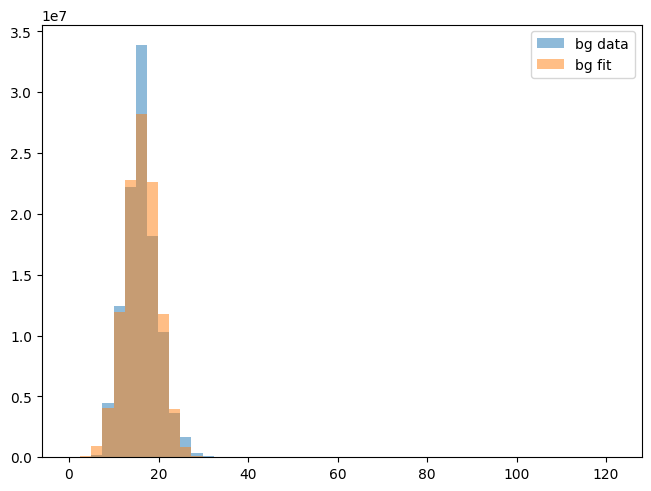

Check the parameters:
{'psf_params_dict': {'na': 1.35, 'wavelength': 680.0, 'refmed': 1.406, 'refcov': 1.524, 'refimm': 1.406, 'objstage0': 0.0, 'zemit0': -0.0, 'pixel_size_xy': (108.0, 108.0), 'otf_rescale_xy': (0.5, 0.5), 'npupil': 64, 'psf_size': 61, 'zernike_mode': array([[ 2., -2.],       [ 2.,  2.],       [ 3., -1.],       [ 3.,  1.],       [ 4.,  0.],       [ 3., -3.],       [ 3.,  3.],       [ 4., -2.],       [ 4.,  2.],       [ 5., -1.],       [ 5.,  1.],       [ 6.,  0.],       [ 4., -4.],       [ 4.,  4.],       [ 5., -3.],       [ 5.,  3.],       [ 6., -2.],       [ 6.,  2.],       [ 7.,  1.],       [ 7., -1.],       [ 8.,  0.]], dtype=float32), 'zernike_coef': array([  80.0306    ,   -4.9659805 ,  -18.640442  ,  -11.997853  ,        -13.120319  ,    4.8778596 ,   32.01234   , -249.03932   ,         -4.6507826 ,  -10.490046  ,    4.638711  ,   -6.888197  ,        -11.407517  ,   -1.073217  ,   -3.394476  ,   -5.3537593 ,        -23.461847  ,   -7.9997697 ,    0.50520444,   

In [3]:
if deeploc_learn_param_widget.exp_file_receiver.files is not None:
    import torch
    import numpy as np
    experimental_images = ailoc.common.read_first_size_gb_tiff(deeploc_learn_param_widget.exp_file_receiver.files, 2)
    camera_calib = ailoc.simulation.instantiate_camera(deeploc_learn_param_widget.deeploc_params_dict['camera_params_dict'])
    experimental_images = ailoc.common.cpu(camera_calib.backward(torch.tensor(experimental_images.astype(np.float32))))
    bg_range = ailoc.common.get_bg_stats_gauss(experimental_images, percentile=10, plot=True)
    
    deeploc_learn_param_widget.deeploc_params_dict['sampler_params_dict']['bg_range'] = bg_range
    
    print('Check the parameters:')
    dict_str = str(deeploc_learn_param_widget.deeploc_params_dict).replace('\n', '')
    print(dict_str)

## 2. Initialize the DeepLoc model

In [4]:
deeploc_model = ailoc.deeploc.DeepLoc(deeploc_learn_param_widget.deeploc_params_dict['psf_params_dict'],
                                      deeploc_learn_param_widget.deeploc_params_dict['camera_params_dict'],
                                      deeploc_learn_param_widget.deeploc_params_dict['sampler_params_dict'])

## 3. Check the PSF model used for training data simulation 

checking PSF...


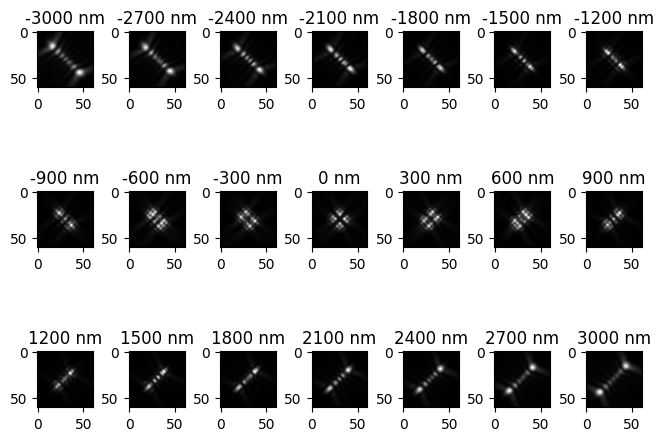

checking training data...


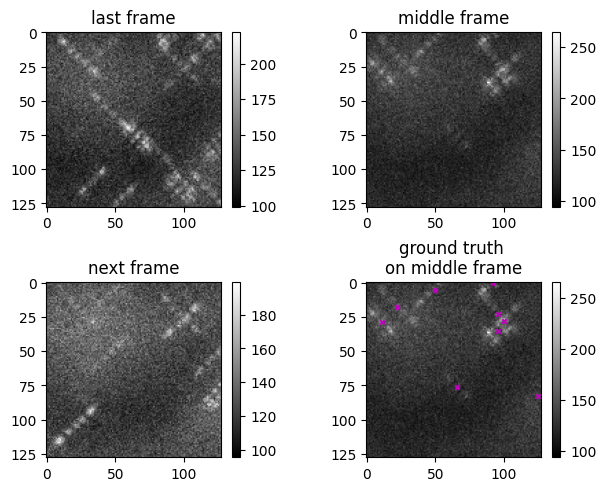

In [5]:
deeploc_model.check_training_psf()
deeploc_model.check_training_data()

## 4. Simulate a validation dataset to track the network performance

In [6]:
deeploc_model.build_evaluation_dataset(napari_plot=False)
display(stackview.slice(deeploc_model.evaluation_dataset['data'][:,0], colormap='turbo', continuous_update=True))

building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([1000, 3, 128, 128]) building done! contain 10044 target molecules, time cost: 25.11s


## 5. Your are ready to go training the network!

In [7]:
file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'DeepLoc.pt'
deeploc_model.online_train(batch_size=10, max_iterations=30000, eval_freq=500, file_name=file_name)

Start training...
Iterations: 500/30000 || Loss: 532.68 || IterTime: 633.01 ms || ETA: 5.19 h
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
Iterations: 1000/30000 || Loss: 180.29 || IterTime: 531.54 ms || ETA: 4.28 h
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 4655, please waiting...
evaluating done! time cost: 11.41s
Iterations: 1500/30000 || Loss: 109.85 || IterTime: 513.20 ms || ETA: 4.06 h || SumProb: 9.71 || Eff_3D: 2.86 || Jaccard: 0.36 || Recall: 0.41 || Precision: 0.76 || RMSE_lat: 38.21 || RMSE_ax: 202.69
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13

DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 7940, please waiting...
evaluating done! time cost: 10.97s
Iterations: 8500/30000 || Loss: 31.49 || IterTime: 460.82 ms || ETA: 2.75 h || SumProb: 10.47 || Eff_3D: 46.41 || Jaccard: 0.59 || Recall: 0.71 || Precision: 0.78 || RMSE_lat: 25.07 || RMSE_ax: 86.02
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 7830, please waiting...
evaluating done! time cost: 10.99s
Iterations: 9000/30000 || Loss: 27.6

----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 7917, please waiting...
evaluating done! time cost: 11.14s
Iterations: 15500/30000 || Loss: 16.90 || IterTime: 468.57 ms || ETA: 1.89 h || SumProb: 9.96 || Eff_3D: 53.83 || Jaccard: 0.60 || Recall: 0.72 || Precision: 0.79 || RMSE_lat: 23.40 || RMSE_ax: 47.56
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 7921, please waiting...
evaluating done! time cost: 11.16s
Iterations: 16000/30000 || Loss: 16.68 || IterTime: 466.92 ms || ETA: 1.82 h || SumProb: 10.05 || Ef

FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 7954, please waiting...
evaluating done! time cost: 11.46s
Iterations: 22500/30000 || Loss: 9.46 || IterTime: 476.38 ms || ETA: 0.99 h || SumProb: 9.83 || Eff_3D: 55.66 || Jaccard: 0.61 || Recall: 0.72 || Precision: 0.79 || RMSE_lat: 21.61 || RMSE_ax: 40.34
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 8030, please waiting...
evaluating done! time cost: 11.52s
Iterations: 23000/30000 || Loss: 9.88 || IterTime: 475.94 ms || ETA: 0.93 h || SumProb: 10.13 || Eff_3D: 55.16 || Jaccard: 0.61 || Recall: 0.73 || Precision: 0.79 || RMSE_lat: 22.36 || RMSE_ax: 44.50
DeepLoc in

evaluating done! time cost: 12.00s
Iterations: 29500/30000 || Loss: 6.37 || IterTime: 499.69 ms || ETA: 0.07 h || SumProb: 9.87 || Eff_3D: 56.07 || Jaccard: 0.61 || Recall: 0.73 || Precision: 0.79 || RMSE_lat: 21.75 || RMSE_ax: 38.57
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
----------------------------------------------------------------------------------------------
evaluating...
FOV=(0, 13824.0, 0, 13824.0) nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 1000 images, ground truth: 8744, predictions: 8001, please waiting...
evaluating done! time cost: 11.75s
Iterations: 30000/30000 || Loss: 6.23 || IterTime: 499.47 ms || ETA: 0.00 h || SumProb: 9.85 || Eff_3D: 56.12 || Jaccard: 0.61 || Recall: 0.73 || Precision: 0.79 || RMSE_lat: 21.27 || RMSE_ax: 38.08
DeepLoc instance saved to ../../results/2023-10-18-16DeepLoc.pt
training finished!


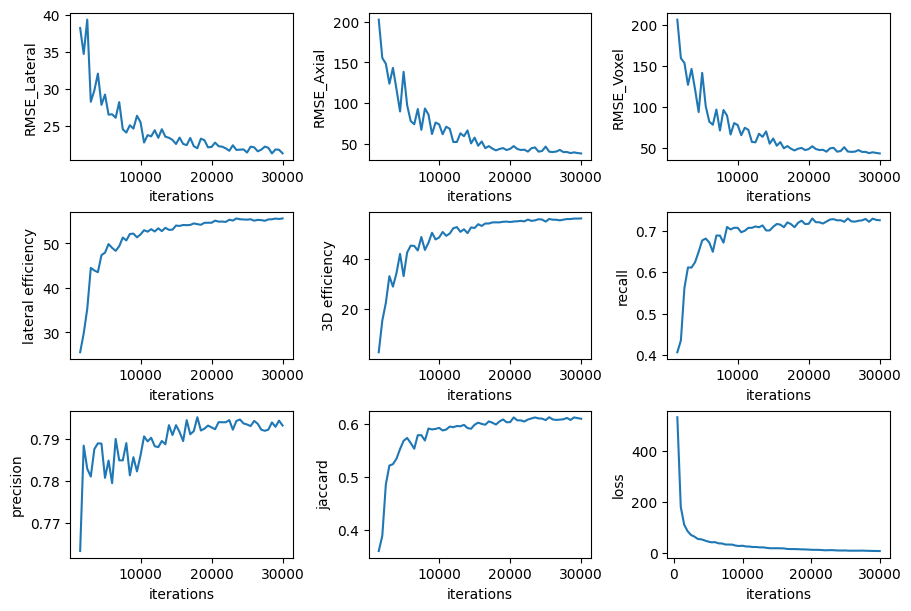

In [8]:
# plot evaluation performance during the training
ailoc.common.plot_train_record(deeploc_model)